In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Kaggle Workshops Starter Notebook [Python version]
## Online Retail Store: Predicting Visitor Behaviour 

<table align="left">
  <td>
    <a href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Online%20Retail%20Store%3A%20Predicting%20Visitor%20Behaviour%20-%20Starter%20Notebook%20%5BPython%5D&download_url=https%3A%2F%2Fstorage.googleapis.com%2Fstarter_notebooks%2Fgoogle_analytics_sample_bqml_python.ipynb&url=https%3A%2F%2Fgist.github.com%2Fpolong-lin%2F51bb01bac82513294e10fb9856c4fdb0">
      <img src="https://cloud.google.com/images/products/ai/ai-solutions-icon.svg" alt="AI Platform Notebooks">Run on AI Platform Notebooks</a>
  </td>
</table>

- [Setup BigQuery in Jupyter](#setup)
- [BigQuery ML basics](#basics)
  - [Select BigQuery data from Python](#select)
  - [Train a BigQuery ML model](#train)
  - [Check models currently being trained on BigQuery](#currentlytraining)
  - [Check if a model has finished training](#finishedtraining)
  - [Evaluate a BigQuery ML model](#evaluate)
  - [Compare multiple models](#compare)
  - [ML.FEATURE_INFO to check input feature information](#featinfo)
  - [Make predictions using BigQuery ML](#predictions)
  - [Export predictions as a CSV file](#exportcsv)
- [Feature engineering](#feateng)
  - [EXTRACT: Extract dates and time](#extractdates)
  - [REGEXP_EXTRACT_ALL: Extract words from a STRING column](#extractwords)
  - [ML.QUANTILE_BUCKETIZE: Bucketize your numeric feature into bins](#bucketize)
  - [ML.POLYNOMIAL_EXPAND: Combine numeric features](#polynomialexpand)
  - [ML.FEATURE_CROSS: Combine categorical features](#featurecross)
- [Feature selection](#featselection)
  - [ML.FEATURE_IMPORTANCE for Boosted Tree models](#featimportance)

<a id="setup"></a>

### Setup BigQuery in Jupyter 

#### Set parameters

In [39]:
#Check current GCP project ID
# !gcloud config get-value project

In [1]:
PROJECT_ID = "globohack-kaggle21-6923" #REPLACE with project ID
DATASET_ID = "bqmlretail"
LOCATION = "EU"

#### Create dataset if it does not yet exist

In [4]:
!bq mk --location=$LOCATION $DATASET_ID

Dataset 'globohack-kaggle21-6923:bqmlretail' successfully created.


#### Required libraries

In [89]:
#!pip install google-cloud-bigquery --upgrade --quiet
# !pip install pandas-profiling
#!pip install pycountry-convert

In [41]:
from google.cloud import bigquery
from google.api_core.exceptions import BadRequest
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

# Construct a BigQuery client object.
client = bigquery.Client()

def bq_query(sql, async_flag=False):
    """
    If `async_flag` set to False (default), 
        returns the query results for `sql` as a Pandas DataFrame, 
    Else, submits query asynchronously and returns nothing.
    """
    
    # Try dry run before executing query to catch any errors
    try:
        job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
        dry_run_job = client.query(sql, job_config=job_config)
    except BadRequest as err:
        print(err)
        return
        
    job_config = bigquery.QueryJobConfig()
    df = client.query(sql, job_config=job_config)
    
    if async_flag:
        return f"Query sent asynchronously for job id: {df.job_id}"
    else:
        df = df.result() #wait for query to finish running
        return df.to_dataframe()
    
    
print("Done.")

Done.


<a id="basics"></a>

## BigQuery ML basics

<a id="select"></a>

#### Select BigQuery data from Python

In [103]:
sql_select = """
SELECT 
  t.* EXCEPT (totalHits, totalVisits, visitStartTime, date, isMobile, browser, city), 
  CAST(isMobile AS INT64) AS isMobile,
  EXTRACT(HOUR FROM TIMESTAMP_MILLIS(visitStartTime*1000)) AS hour,
  EXTRACT(DAY FROM TIMESTAMP_MILLIS(visitStartTime*1000)) AS day,
  IF (EXTRACT(DAYOFWEEK FROM TIMESTAMP_MILLIS(visitStartTime*1000)) IN (1,7), 1, 0) AS isWeekend
FROM
  kaggleworkshops.google_analytics_sample_eu.train t
WHERE date BETWEEN TIMESTAMP("2016-08-01")
  AND TIMESTAMP("2016-10-31")
"""

df = bq_query(sql = sql_select)

df.tail()

,fullVisitorId,deviceCategory,operatingSystem,browser,country,city,trafficSource,trafficMedium,trafficCampaign,isFirstVisit,totalPageviews,totalTimeOnSite,productPagesViewed,addedToCart,isMobile,hour,day,isWeekend
243292,4757286408362678255,desktop,Windows,Chrome,United States,Seattle,uweoconnect.extn.washington.edu,referral,(not set),1,1,0,0,0,0,2,19,0
243293,0112313025021493147,desktop,Windows,Chrome,United States,not available in demo dataset,uweoconnect.extn.washington.edu,referral,(not set),1,1,0,0,0,0,3,28,0
243294,5128790713477036814,desktop,Macintosh,Chrome,United States,Seattle,uweoconnect.extn.washington.edu,referral,(not set),1,1,0,0,0,0,2,19,0
243295,5202168656086679244,desktop,Macintosh,Chrome,United States,San Francisco,uweoconnect.extn.washington.edu,referral,(not set),1,2,438,0,0,0,2,19,0
243296,7240535066211839362,desktop,Windows,Chrome,United States,San Francisco,uweoconnect.extn.washington.edu,referral,(not set),1,1,0,0,0,0,2,19,0


In [104]:
df.dtypes

fullVisitorId         object
deviceCategory        object
operatingSystem       object
browser               object
country               object
city                  object
trafficSource         object
trafficMedium         object
trafficCampaign       object
isFirstVisit           int64
totalPageviews         int64
totalTimeOnSite        int64
productPagesViewed     int64
addedToCart            int64
isMobile               int64
hour                   int64
day                    int64
isWeekend              int64
dtype: object

### Exploratory Data Analysis

In [90]:
# %%time
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# profile

In [5]:
df.columns


Index(['fullVisitorId', 'deviceCategory', 'isMobile', 'browser', 'country',
       'city', 'trafficSource', 'trafficMedium', 'trafficCampaign',
       'isFirstVisit', 'totalVisits', 'totalPageviews', 'totalTimeOnSite',
       'productPagesViewed', 'addedToCart', 'hour', 'day', 'isWeekend',
       'operatingSystem'],
      dtype='object')

In [52]:
@np.vectorize
def get_continent_code(country):
    
    try:
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")

        return pc.country_alpha2_to_continent_code(country_code)
    except:
        return 'Other'


# get_continent_code(df.country.unique())

<BarContainer object of 2 artists>

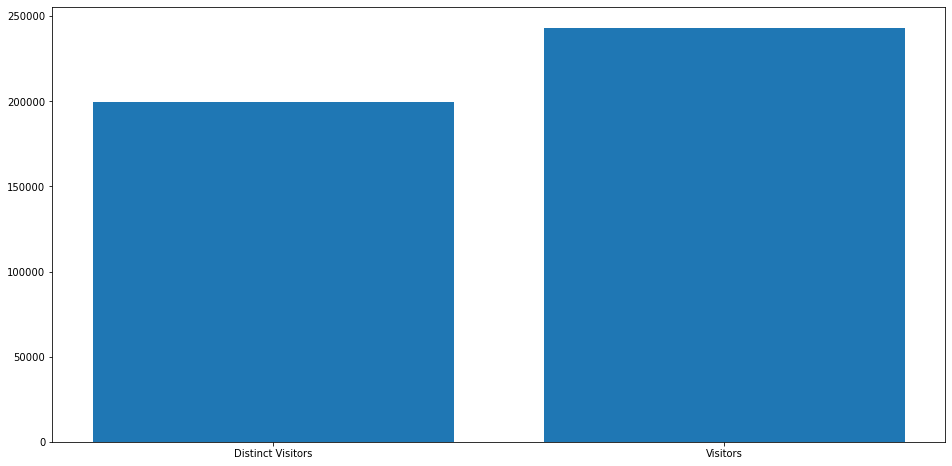

In [19]:
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(['Distinct Visitors', 'Visitors'], [df.fullVisitorId.nunique(), df.shape[0]])

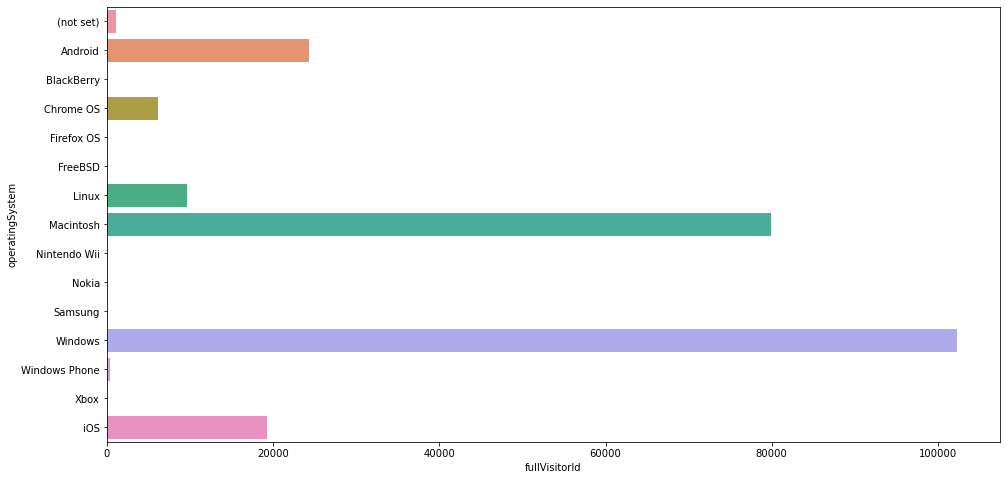

In [65]:
def plot_categorical_variable(column: str, figsize=(16,8)):
    fig, ax = plt.subplots(figsize=figsize)
    df_plot = pd.DataFrame(df.groupby(column)['fullVisitorId'].count()).reset_index(drop=False)
    sns.barplot(data=df_plot, x="fullVisitorId", y=column, ax=ax)
    fig.savefig(f'./plots/{column}.jpeg', bbox_inches='tight')
    
column = 'operatingSystem'
plot_categorical_variable(column)



In [97]:
@np.vectorize
def binarize_time_on_site(time, threshold=5):
    return 1 if time > 5 else 0

@np.vectorize
def binarize_product_pages_viewed(pv):
    if pv <= 1:
        return 1
    elif pv > 1 and pv <= 3:
        return 2
    elif pv > 3:
        return 5
    return 0

@np.vectorize
def get_cyclic_day(day):
    return np.sin(2 * np.pi * (day-1) / 30)

@np.vectorize
def get_cyclic_hour(hour):
    return np.sin(2 * np.pi * (hour) / 24)


In [108]:
@np.vectorize
def binarize_os_category(os):
    if os in ['Macintosh', 'iOS']:
        return 1
    elif os in ['Android', 'Chrome OS', 'Linux', 'Windows', 'BlackBerry', 'Firefox OS', 'FreeBSD', 'Nintendo Wii', 'Nokia', 'Samsung', 'Windows Phone', 'Xbox']:
        return -1
    return 0

binarize_os_category(df.operatingSystem.unique())

array([-1, -1,  1,  1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


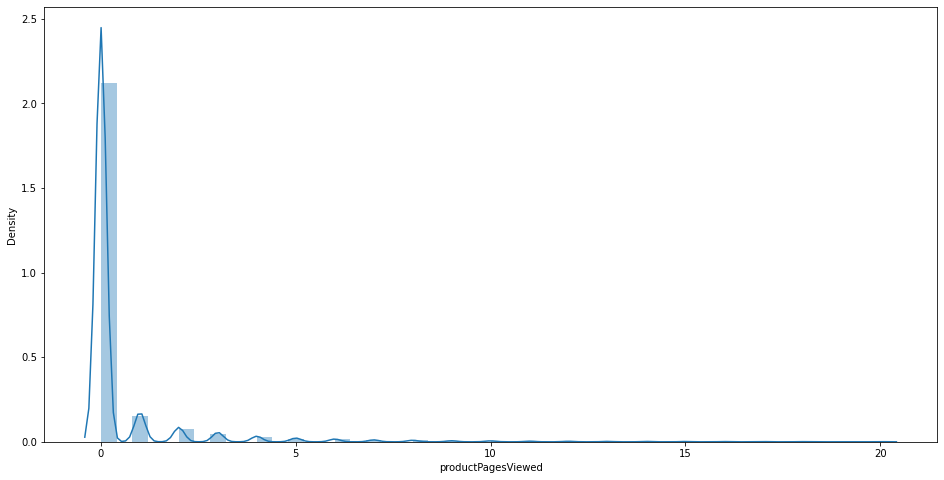

In [94]:
def plot_numerical_variable(column:str, figsize=(16,8), log=False, max_value=None):
    fig, ax = plt.subplots(figsize=figsize)
    df_plot = df.copy()
    if max_value:
        df_plot = df_plot.query(f'{column} <= {max_value}')
    
    if log:
        sns.distplot(np.log(1+df_plot[column]), ax=ax)
    else:
        sns.distplot(df_plot[column], ax=ax)
    
plot_numerical_variable('productPagesViewed', log=False, max_value = 20)

## Preprocessing

### Categorical
- `deviceCategory`: oneHotEncoding
- `isMobile`: cast to integer
- `browser`: ignored (device category is enough)
- `country`: get_continent_code and oneHotEncoding
- `city`: ignored
- `trafficSource`: ignored (?)
- `trafficMedium`: ignored (?)
- `trafficCampaign`: ignored (?)
- `operatingSystem`: binarize_os_category

### Numerical
- `isFirstVisit`: leave as is
- `totalVisits`: ignored
- `totalPageviews`: log (but we could binarize as well (like light/medium/heavy user)
- `totalTimeOnSite`: threshold on 5
- `productPagesViewed`: binarize_product_pages_viewed
- `addedToCart`
- `hour`: sine
- `day`: sine
- `isWeekend`: leave as is


In [106]:
drop_columns = []

In [107]:
df['country_continent_code'] = df['country'].apply(get_continent_code)
drop_columns.append('country')
# One Hot Encoding



In [109]:
df['operating_system_bin'] = df['operatingSystem'].apply(binarize_os_category)

In [111]:
df['total_pageviews_log'] = np.log(1+df['totalPageviews'])
df['time_on_site_bin'] = df['totalTimeOnSite'].apply(binarize_time_on_site)

drop_columns.append('totalPageviews')
drop_columns.append('totalTimeOnSite')

In [83]:
def get_relation(data: pd.DataFrame(), col: str):
    relation_df = pd.DataFrame(data\
        .groupby(by=[col, 'addedToCart'])\
        .count()['fullVisitorId']).reset_index()\
        .pivot(index=col, columns='addedToCart', values='fullVisitorId')
    relation_df['percent'] = relation_df[1] / (relation_df[0]+relation_df[1])
    return relation_df

get_relation(df, 'trafficMedium')

addedToCart,0,1,percent
trafficMedium,,,
(none),16058.0,2742.0,0.145851
(not set),2.0,NaN,NaN
affiliate,1752.0,157.0,0.082242
cpc,1331.0,136.0,0.092706
cpm,394.0,55.0,0.122494
organic,22121.0,2022.0,0.083751
referral,27669.0,320.0,0.011433


<a id="train"></a>

#### Train a BigQuery ML model

In [8]:
sql_logreg_sample = """
CREATE OR REPLACE MODEL bqmlretail.logreg_sample
TRANSFORM(
  LOWER(country) country_lower,
  totalPageviews,
  addedToCart
)
OPTIONS(
  model_type='logistic_reg', 
  INPUT_LABEL_COLS=["addedToCart"]) AS
SELECT 
  *
FROM
  kaggleworkshops.google_analytics_sample_eu.train
WHERE date BETWEEN TIMESTAMP("2016-08-01")
  AND TIMESTAMP("2016-08-31")
"""

#send asynchronously
bq_query(sql = sql_logreg_sample,
        async_flag=True)

'Query sent asynchronously for job id: 6b15a614-2803-40dc-aa9f-f4cc6b5008ee'

Other model types for classification:
 - [`logistic_reg`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create)
 - [`boosted_tree_classifier`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree)
 - [`dnn_classifier`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-dnn-models)
 - [`automl_classifier`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-automl)

<a id="currentlytraining"></a>

#### Check models currently being trained on BigQuery

This will check if the models in your project are still undergoing training.

In [9]:
sql_currentlyrunningqueries = f"""
SELECT
    job_id,
    creation_time,
    query,
    REGEXP_EXTRACT(query, r'{DATASET_ID}\.\w+') AS modelname
FROM `region-eu`.INFORMATION_SCHEMA.JOBS_BY_USER
WHERE 
    REGEXP_CONTAINS(LOWER(query), 'create (or replace ){{0,1}}model')
    AND NOT REGEXP_CONTAINS(LOWER(query), 'information_schema')
    AND state != "DONE"
"""

print(sql_currentlyrunningqueries)

#send asynchronously
models_still_training = bq_query(sql_currentlyrunningqueries)

print(f"{len(models_still_training)} models still currently training:")
models_still_training


SELECT
    job_id,
    creation_time,
    query,
    REGEXP_EXTRACT(query, r'bqmlretail\.\w+') AS modelname
FROM `region-eu`.INFORMATION_SCHEMA.JOBS_BY_USER
WHERE 
    REGEXP_CONTAINS(LOWER(query), 'create (or replace ){0,1}model')
    AND NOT REGEXP_CONTAINS(LOWER(query), 'information_schema')
    AND state != "DONE"

1 models still currently training:


,job_id,creation_time,query,modelname
0,6b15a614-2803-40dc-aa9f-f4cc6b5008ee,2021-11-08 15:47:40.087000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.logreg_sample\nTRANSFORM(\n LOWER(country) country_lower,\n totalPageviews,\n addedToCart\n)\nOPTIONS(\n model_type='logistic_reg', \n INPUT_LABEL_COLS=[""...",bqmlretail.logreg_sample


<a id="finishedtraining"></a>

#### Check which models have finished training

In [10]:
sql_finished_queries = f"""
SELECT
    job_id,
    creation_time,
    query,
    REGEXP_EXTRACT(query, r'{DATASET_ID}\.\w+') AS modelname
FROM `region-eu`.INFORMATION_SCHEMA.JOBS_BY_USER
WHERE 
    REGEXP_CONTAINS(LOWER(query), 'create (or replace ){{0,1}}model')
    AND NOT REGEXP_CONTAINS(LOWER(query), 'information_schema')
    AND state = "DONE"
ORDER BY creation_time DESC
"""

print(sql_finished_queries)

finished_models = bq_query(sql_finished_queries)
finished_models.head()


SELECT
    job_id,
    creation_time,
    query,
    REGEXP_EXTRACT(query, r'bqmlretail\.\w+') AS modelname
FROM `region-eu`.INFORMATION_SCHEMA.JOBS_BY_USER
WHERE 
    REGEXP_CONTAINS(LOWER(query), 'create (or replace ){0,1}model')
    AND NOT REGEXP_CONTAINS(LOWER(query), 'information_schema')
    AND state = "DONE"
ORDER BY creation_time DESC



,job_id,creation_time,query,modelname
0,6b15a614-2803-40dc-aa9f-f4cc6b5008ee,2021-11-08 15:47:40.087000+00:00,"\nCREATE OR REPLACE MODEL bqmlretail.logreg_sample\nTRANSFORM(\n LOWER(country) country_lower,\n totalPageviews,\n addedToCart\n)\nOPTIONS(\n model_type='logistic_reg', \n INPUT_LABEL_COLS=[""...",bqmlretail.logreg_sample


<a id="evaluate"></a>

#### Evaluate a BigQuery ML model

In [11]:
MODEL_NAME = "logreg_sample"

sql_logreg_sample = f"""
SELECT 
  *
FROM
  ML.EVALUATE(
      MODEL {DATASET_ID}.{MODEL_NAME})
"""

print(sql_logreg_sample)

bq_query(sql = sql_logreg_sample)


SELECT 
  *
FROM
  ML.EVALUATE(
      MODEL bqmlretail.logreg_sample)



,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.74124,0.37112,0.943478,0.494604,0.162859,0.932254


<a id="compare"></a>

### Compare multiple models

In [12]:
MODEL_LIST = ["logreg_sample", 
              "logreg_sample", 
              "logreg_sample"] #change or add models here

sql_modeleval_list = [f"SELECT \n  '{modelname}' as modelname, \n  * \nFROM \n  ML.EVALUATE(MODEL {DATASET_ID}.{modelname})"
                      for modelname 
                      in MODEL_LIST]

sql_compare_evaluation = "\n\nUNION ALL\n\n".join(sql_modeleval_list)

print(sql_compare_evaluation)

bq_query(sql_compare_evaluation)

SELECT 
  'logreg_sample' as modelname, 
  * 
FROM 
  ML.EVALUATE(MODEL bqmlretail.logreg_sample)

UNION ALL

SELECT 
  'logreg_sample' as modelname, 
  * 
FROM 
  ML.EVALUATE(MODEL bqmlretail.logreg_sample)

UNION ALL

SELECT 
  'logreg_sample' as modelname, 
  * 
FROM 
  ML.EVALUATE(MODEL bqmlretail.logreg_sample)


,modelname,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,logreg_sample,0.74124,0.37112,0.943478,0.494604,0.162859,0.932254
1,logreg_sample,0.74124,0.37112,0.943478,0.494604,0.162859,0.932254
2,logreg_sample,0.74124,0.37112,0.943478,0.494604,0.162859,0.932254


<a id="featinfo"></a>

### ML.FEATURE_INFO to check input feature information

The ML.FEATURE_INFO function allows you to see information about the input features used to train a model. [ML.FEATURE_INFO Documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature)

In [13]:
MODEL_NAME = "logreg_sample"

sql_featureinfo = f"""
SELECT
    *
FROM
    ML.FEATURE_INFO(MODEL bqmlretail.{MODEL_NAME})
"""

bq_query(sql_featureinfo)

,input,min,max,mean,median,stddev,category_count,null_count
0,country,NaN,NaN,NaN,NaN,NaN,179.0,0
1,totalPageviews,0.0,469.0,4.837216,2.0,10.022497,NaN,0


<a id="predictions"></a>

### Make predictions using BigQuery ML

In [14]:
MODEL_NAME = "logreg_sample"

sql_predict = f"""
SELECT
  sessionId, 
  prob as addedToCart
FROM
  ML.PREDICT(MODEL {DATASET_ID}.{MODEL_NAME},
    (
    SELECT 
      CONCAT(fullVisitorId, CAST(visitStartTime as string)) as sessionId, 
      *
    FROM
    `kaggleworkshops.google_analytics_sample_eu.test`
  )),
UNNEST(predicted_addedToCart_probs)
WHERE label = 1
"""

print(sql_predict)

submission = bq_query(sql_predict)
submission.head()


SELECT
  sessionId, 
  prob as addedToCart
FROM
  ML.PREDICT(MODEL bqmlretail.logreg_sample,
    (
    SELECT 
      CONCAT(fullVisitorId, CAST(visitStartTime as string)) as sessionId, 
      *
    FROM
    `kaggleworkshops.google_analytics_sample_eu.test`
  )),
UNNEST(predicted_addedToCart_probs)
WHERE label = 1



,sessionId,addedToCart
0,07882694182815421261496681584,0.041283
1,40290108148527355581500581209,0.031035
2,12903768516128460481500783647,0.030220
3,54265335888974045141496444163,0.035337
4,23723569795764538441501119781,0.117831


<a id="exportcsv"></a>

### Export predictions for Kaggle as a CSV file

In [15]:
MODEL_NAME = "logreg_sample"

#save as CSV
submission.to_csv(f"submission_{MODEL_NAME}.csv", index=False)

The predictions are now saved to a CSV file. To download the file to your computer, locate your file in the left-menu in JupyterLab, right-click on it and click "Download". You can now make a submission to the Kaggle competition with the file.

<hr><a id="feateng"></a>

## Preprocessing Functions in BigQuery ML
You can use [TRANSFORM()](https://cloud.google.com/bigquery-ml/docs/bigqueryml-transform) with any of the [preprocessing functions](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions) below.

<a id="extractdates"></a>

#### EXTRACT: Extract dates and time

[EXTRACT from DATE documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#extract)  
[EXTRACT from TIMESTAMP documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/timestamp_functions#extract)

In [10]:
sql_datetime = """
    SELECT
        date,
        EXTRACT( month FROM date) as month,
        EXTRACT( dayofweek FROM date) AS dayofweek,
        EXTRACT( day FROM date) as day,
        
        visitStartTime,
        EXTRACT( hour FROM TIMESTAMP_SECONDS(visitStartTime) ) as hour
    FROM
        kaggleworkshops.google_analytics_sample_eu.train
    LIMIT 10
    """

bq_query(sql_datetime, 
         async_flag = False)

,date,month,dayofweek,day,visitStartTime,hour
0,2016-10-14 00:00:00+00:00,10,6,14,1476492957,0
1,2017-04-30 00:00:00+00:00,4,1,30,1493611205,4
2,2017-03-20 00:00:00+00:00,3,2,20,1490071147,4
3,2017-04-01 00:00:00+00:00,4,7,1,1491048053,12
4,2017-05-20 00:00:00+00:00,5,7,20,1495292376,14
5,2017-05-14 00:00:00+00:00,5,1,14,1494792010,20
6,2017-05-17 00:00:00+00:00,5,4,17,1495047452,18
7,2017-05-15 00:00:00+00:00,5,2,15,1494883945,21
8,2016-10-11 00:00:00+00:00,10,3,11,1476231674,0
9,2016-10-10 00:00:00+00:00,10,2,10,1476144607,0


<a id="extractwords"></a>

#### REGEXP_EXTRACT_ALL: Extract words from a STRING column
[REGEXP_EXTRACT_ALL Documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/string_functions#regexp_extract_all)

In [14]:
sql_words = """
SELECT 
  trafficCampaign, 
  REGEXP_EXTRACT_ALL(trafficCampaign, 
                      r"[a-zA-Z]+"
                    ) as extracted_words 

FROM 
  kaggleworkshops.google_analytics_sample_eu.train
LIMIT 5
"""

bq_query(sql_words)

,trafficCampaign,extracted_words
0,(not set),"[not, set]"
1,(not set),"[not, set]"
2,(not set),"[not, set]"
3,(not set),"[not, set]"
4,(not set),"[not, set]"


<a id="bucketize"></a>

#### ML.QUANTILE_BUCKETIZE: Bucketize your numeric feature into bins
[ML.QUANTILE_BUCKETIZE Documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#quantile_bucketize)

In [12]:
sql_bucketize = """
SELECT 
    totalTimeOnSite,
    ML.QUANTILE_BUCKETIZE(totalTimeOnSite,
                            100 #number of buckets
                         ) OVER() AS bucket_totalTimeOnSite,
FROM
    kaggleworkshops.google_analytics_sample_eu.train
LIMIT 10
"""

bq_query(sql_bucketize)

,totalTimeOnSite,bucket_totalTimeOnSite
0,0,bin_1
1,0,bin_1
2,0,bin_1
3,302,bin_41
4,0,bin_1
5,0,bin_1
6,183,bin_36
7,7,bin_5
8,543,bin_45
9,164,bin_35


<a id="polynomialexpand"></a>

#### ML.POLYNOMIAL_EXPAND: Combine numeric features

[ML.POLYNOMIAL_EXPAND Documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#mlpolynomial_expand)

In [40]:
sql_polynomialexpand = """
SELECT
    ML.POLYNOMIAL_EXPAND(STRUCT(totalHits, totalPageViews), 
                          2) AS x
FROM
    kaggleworkshops.google_analytics_sample_eu.train
LIMIT 3
"""

bq_query(sql_polynomialexpand)

,x
0,"{'totalHits': 27.0, 'totalHits_totalHits': 729.0, 'totalHits_totalPageViews': 621.0, 'totalPageViews': 23.0, 'totalPageViews_totalPageViews': 529.0}"
1,"{'totalHits': 23.0, 'totalHits_totalHits': 529.0, 'totalHits_totalPageViews': 414.0, 'totalPageViews': 18.0, 'totalPageViews_totalPageViews': 324.0}"
2,"{'totalHits': 23.0, 'totalHits_totalHits': 529.0, 'totalHits_totalPageViews': 368.0, 'totalPageViews': 16.0, 'totalPageViews_totalPageViews': 256.0}"


<a id="featurecross"></a>

#### ML.FEATURE_CROSS: Combine categorical features

[ML.FEATURE_CROSS Documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#mlfeature_cross)

In [39]:
sql_featurecross = """
SELECT
    country,
    deviceCategory,
    ML.FEATURE_CROSS(STRUCT(country, deviceCategory), 
                    2) AS x
FROM
    kaggleworkshops.google_analytics_sample_eu.train
LIMIT 3
"""

bq_query(sql_featurecross)

,country,deviceCategory,x
0,United Kingdom,mobile,{'country_deviceCategory': 'United Kingdom_mobile'}
1,Taiwan,mobile,{'country_deviceCategory': 'Taiwan_mobile'}
2,Taiwan,mobile,{'country_deviceCategory': 'Taiwan_mobile'}


<a id="featselection"></a>
<hr>

## Feature Selection

<a id="featimportance"></a>

### ML.FEATURE_IMPORTANCE for Boosted Tree models

_Note: This function is only available for Boosted Tree models (`boosted_tree_classifier` or `boosted_tree_regressor`)._

The ML.FEATURE_IMPORTANCE function allows you to see feature importance score, which indicates how useful or valuable each feature was in the construction of the Boosted Tree model during training. [ML.FEATURE_IMPORTANCE Documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-importance#mlfeature_importance_function)

In [ ]:
MODEL_NAME = "MY_BOOSTED_TREE_MODEL_NAME"

sql_featureimportance = f"""
SELECT
    *
FROM
    ML.FEATURE_IMPORTANCE(MODEL bqmlretail.{MODEL_NAME})
"""

bq_query(sql_featureimportance)